# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

*By Surya Soujanya Kodavalla*

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find the trending food places in each suburb of Sydney, Australia which are closest to the train stations. Specifically, this report will be targeted to travelers, especially solo travelers, interested in visiting the top food places which are are convenient to travel to and from in Sydney.

This project has been done keeping in mind that local travel and food are main concerns of any traveler when going to a new city. The analysis  has been done on all the suburbs in Sydney. The food places have been clustered based on their distance from train stations. We are particularly focusing on the train stations in Sydney as their metro network is very reliable with services running from 4am to around midnight on most train lines. 

Data science and the K-means clustering algorithm has been used to get useful data and generate different clusters of food places all over Sydney based on their distances from the nearest train stations.

In [1]:
import pandas as pd
import numpy as np

import requests
import csv

import json
from pandas.io.json import json_normalize

from geopy.geocoders import Nominatim 
from geopy.exc import GeocoderTimedOut
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium

print('Libraries imported.')

Libraries imported.


## Data <a name="data"></a>

Based on definition of the problem, data needed for analysis is:
* list of suburbs in Sydney and their locations
* list of train stations in Sydney and their locations
* top food venues in different suburbs
* distance between food venues and the nearest train station

#### List of Suburbs in Sydney and their locations -

* Data for list of suburbs in Sydney was scraped from the [Wikipedia page](https://en.wikipedia.org/wiki/List_of_Sydney_suburbs) and it was cleaned by removing extra parts of the code from in between the data and other extra characters through multiple iterations. The scraped and cleaned list of suburbs was then made into a dataframe and stored as a csv file.

* While adding the latitudes and longitudes of each of the suburbs to the dataset, using the geopy package, the location 'Sydney, Australia' was added to the address to get the accurate location as there can possibly be many places with the same name in different cities.

* The link to the data set is available [here](https://www.kaggle.com/ssk27997/suburbs-in-sydney-australia).

* The link to the code used for scraping is available [here](https://github.com/surya-soujanya/Coursera_Capstone/blob/master/Suburbs%20Scraping.ipynb).

In [2]:
sydney_suburbs = pd.read_csv('sydney_suburbs.csv')
sydney_suburbs.dropna(inplace=True)
sydney_suburbs.reset_index(inplace=True)
sydney_suburbs.drop(['index'],inplace=True,axis=1)
sydney_suburbs

,Suburb,Latitude,Longitude
0,Abbotsbury,-33.869285,150.866703
1,Abbotsford,-33.850553,151.129759
2,Acacia Gardens,-33.732459,150.912532
3,Agnes Banks,-33.614508,150.711448
4,Airds,-34.090000,150.826111
...,...,...,...
673,Yennora,-33.862008,150.968610
674,Yowie Bay,-34.050278,151.103333
675,Zetland,-33.907662,151.208218
676,Jordan Springs,-33.725022,150.727127


#### List of Train Stations in Sydney and their locations -

* Similar to the dataset for the suburbs, the dataset for the railway stations was scraped using beautifulsoup from the  [Wikipedia page](https://en.wikipedia.org/wiki/List_of_Sydney_Trains_railway_stations). It was cleaned by removing extra parts of the code from in between the data and other extra characters through multiple iterations. The words 'Railway Station' were added to each of the names of the stations to make location then easier. The scraped and cleaned list of railway stations was then made into a dataframe and stored as a csv file.

* While adding the latitudes and longitudes of each of the stations to the dataset, using the geopy package, the location 'Sydney, Australia' was added to the address to get the accurate location as there can possibly be many places with the same name in different cities.

* The link to the data set is available [here](https://www.kaggle.com/ssk27997/train-stations-in-sydney-australia).

* The link to the code used for scraping is available [here](https://github.com/surya-soujanya/Coursera_Capstone/blob/master/Stations%20Scraping.ipynb).

In [3]:
sydney_stations=pd.read_csv("sydney_stations.csv")
sydney_stations.dropna(inplace=True)
sydney_stations.reset_index(inplace=True)
sydney_stations.drop(['index'],inplace=True,axis=1)
sydney_stations

,Station,Latitude,Longitude
0,Mount Kuring-gai Railway Station,-33.653064,151.136886
1,Ingleburn Railway Station,-33.998333,150.851111
2,Yennora Railway Station,-33.862008,150.968610
3,Epping Railway Station,-33.772863,151.082090
4,Rooty Hill Railway Station,-33.768865,150.841180
...,...,...,...
163,Mulgrave Railway Station,-33.627219,150.831660
164,Croydon Railway Station,-33.877794,151.115650
165,Punchbowl Railway Station,-33.928717,151.052259
166,Mascot Railway Station,-33.928956,151.195178


In [4]:
#Obtain the latitude and longitude of Sydney
address = 'Sydney, Australia'
geolocator = Nominatim(user_agent="Sydney_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sydney are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sydney are -33.8548157, 151.2164539.


###### Visualization of the two data sets obtained above by plotting them on a map.

In [5]:
map_sydney = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, suburb in zip(sydney_suburbs['Latitude'], sydney_suburbs['Longitude'], sydney_suburbs['Suburb']):
    label = '{}'.format(suburb )
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
        radius=3,
        popup=label,
        color='#1E90FF',
        fill=True,
        fill_color='#00BFFF',
        fill_opacity=0.8,
        parse_html=False).add_to(map_sydney)  

for lat, lng, station in zip(sydney_stations['Latitude'], sydney_stations['Longitude'], sydney_stations['Station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
        radius=5,
        popup=label,
        color='#008000',
        fill=True,
        fill_color='#3CB371	',
        fill_opacity=0.8,
        parse_html=False).add_to(map_sydney)  
    
map_sydney

#### Top food places and their locations - 
The food places in each suburb will be obtained by using the Foursquare API on the suburbs dataset. The category ID for food places is used to return only the food places in the specified areas.The required details of each venue such as latitude and longitude are obtained from the json file generated.

In [6]:
import urllib
def getNearbyVenues(names, latitudes, longitudes, radius=3000, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, 
                                                                                                                                       CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            response = requests.get(url).json()
            results = response["response"]['venues']
            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Suburb', 
                  'Suburb Latitude', 
                  'Suburb Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [7]:
CLIENT_ID = 'XIGGCC3DSUICPZOBTPEVSLHEDW5JXYW4MCHZA2SG5N4TJUUG' 
CLIENT_SECRET = 'JFT241ZRHU3DU2XL2YBOPYXQROEK332GWIOYZ4BHTO5DQMBJ' 
VERSION = '20180604'
LIMIT = 20

In [8]:
top_food_places = getNearbyVenues(names=sydney_suburbs['Suburb'], latitudes=sydney_suburbs['Latitude'], longitudes=sydney_suburbs['Longitude'], 
                                  radius=3000, categoryIds='4d4b7105d754a06374d81259')
#categoryIds is 4d4b7105d754a06374d81259 as it returns all the food places
top_food_places

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbotsbury,-33.869285,150.866703,Star Buffet (Club Marconi),-33.864698,150.879435,Buffet
1,Abbotsbury,-33.869285,150.866703,Soju,-33.857248,150.898864,Korean Restaurant
2,Abbotsbury,-33.869285,150.866703,McDonald's,-33.888236,150.881752,Fast Food Restaurant
3,Abbotsbury,-33.869285,150.866703,The Grove Food Court,-33.858911,150.898981,Food Court
4,Abbotsbury,-33.869285,150.866703,The Moose Man Kebab,-33.887770,150.896010,Food Truck
...,...,...,...,...,...,...,...
12419,South Granville,-33.857778,151.010556,Suliya Gogiya,-33.864365,151.044980,BBQ Joint
12420,South Granville,-33.857778,151.010556,Darband Persian Restaraunt,-33.849675,151.034835,Persian Restaurant
12421,South Granville,-33.857778,151.010556,Khaybar Authentic Afghan Cuisine,-33.853292,151.032504,Afghan Restaurant
12422,South Granville,-33.857778,151.010556,Kabul House Restaurant,-33.836492,150.989744,Afghan Restaurant


## Methodology <a name="methodology"></a>

In this project the plan is to cluster the food places based on their distances from the nearest railway stations.

In first step we have collected the required data as shown above by data scraping, cleaning and using geopy and the Foursquare API.

The second step will be calculation and exploration of the nearest railway station to each food place and the distance between them. This data is then combined with the dataset of top food places that we previously obtained.

The third and final step will be focusing on clustering these food places based on their distances from the nearest railway stations and exploring the clusters made. A visualization of the clusters obtained will be made by plotting a few points of each cluster on a map along with the railway stations. The data obtained can be used to explore the suburbs as per the requirement of the traveler.

In [9]:
venue_lats = top_food_places['Venue Latitude']
venue_longs=top_food_places['Venue Longitude']
station_lats=sydney_stations['Latitude']
station_longs=sydney_stations['Longitude']
stations=sydney_stations['Station']

a,b=top_food_places.shape
c,d=sydney_stations.shape

#changed due to issues with nan data
station_lats[72]=0
station_longs[72]=0

<ipython-input-9-4971e7bc470e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_lats[72]=0
<ipython-input-9-4971e7bc470e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_longs[72]=0


###### Calculation of the distance of the nearest railway station from each food place.

In [10]:
from geopy.distance import great_circle

nearest_station=[None] * a
distance= [None] * a

i=0
for i in range(a):
    venue=(venue_lats[i],venue_longs[i])
    dist=float('inf')
    j=0
    for j in range(c):
        station=(station_lats[j],station_longs[j])
        temp=great_circle(venue,station).km
        if(temp<dist):
            dist = temp
            distance[i] = temp
            nearest_station[i]=stations[j]

In [11]:
len(nearest_station)

12424

In [12]:
len(distance)

12424

In [13]:
#Combine the calculations obtained with the dataset previously used
top_food_places.insert(loc=7,column="Nearest Station",value=nearest_station) 
top_food_places.insert(loc=8,column="Distance to Nearest Station in km",value=distance) 
top_food_places

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Nearest Station,Distance to Nearest Station in km
0,Abbotsbury,-33.869285,150.866703,Star Buffet (Club Marconi),-33.864698,150.879435,Buffet,Cabramatta Railway Station,6.306210
1,Abbotsbury,-33.869285,150.866703,Soju,-33.857248,150.898864,Korean Restaurant,Fairfield Railway Station,5.232940
2,Abbotsbury,-33.869285,150.866703,McDonald's,-33.888236,150.881752,Fast Food Restaurant,Cabramatta Railway Station,4.991601
3,Abbotsbury,-33.869285,150.866703,The Grove Food Court,-33.858911,150.898981,Food Court,Fairfield Railway Station,5.164394
4,Abbotsbury,-33.869285,150.866703,The Moose Man Kebab,-33.887770,150.896010,Food Truck,Cabramatta Railway Station,3.736942
...,...,...,...,...,...,...,...,...,...
12419,South Granville,-33.857778,151.010556,Suliya Gogiya,-33.864365,151.044980,BBQ Joint,Lidcombe Railway Station,0.158246
12420,South Granville,-33.857778,151.010556,Darband Persian Restaraunt,-33.849675,151.034835,Persian Restaurant,Auburn Railway Station,1.014216
12421,South Granville,-33.857778,151.010556,Khaybar Authentic Afghan Cuisine,-33.853292,151.032504,Afghan Restaurant,Auburn Railway Station,0.656122
12422,South Granville,-33.857778,151.010556,Kabul House Restaurant,-33.836492,150.989744,Afghan Restaurant,Merrylands Railway Station,0.376751


###### Clustering the food places based on the distances to the nearest railway station.

In [14]:
clustering = pd.DataFrame(columns=['Distance to Nearest Station in km'])
clustering['Distance to Nearest Station in km'] = top_food_places['Distance to Nearest Station in km']
kmeans = KMeans(n_clusters=5, random_state=0).fit(clustering)

In [15]:
clusters = kmeans.labels_
len(clusters)

12424

In [16]:
top_food_places.insert(loc=9,column="Cluster Labels",value=clusters) 
top_food_places

,Suburb,Suburb Latitude,Suburb Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Nearest Station,Distance to Nearest Station in km,Cluster Labels
0,Abbotsbury,-33.869285,150.866703,Star Buffet (Club Marconi),-33.864698,150.879435,Buffet,Cabramatta Railway Station,6.306210,4
1,Abbotsbury,-33.869285,150.866703,Soju,-33.857248,150.898864,Korean Restaurant,Fairfield Railway Station,5.232940,4
2,Abbotsbury,-33.869285,150.866703,McDonald's,-33.888236,150.881752,Fast Food Restaurant,Cabramatta Railway Station,4.991601,4
3,Abbotsbury,-33.869285,150.866703,The Grove Food Court,-33.858911,150.898981,Food Court,Fairfield Railway Station,5.164394,4
4,Abbotsbury,-33.869285,150.866703,The Moose Man Kebab,-33.887770,150.896010,Food Truck,Cabramatta Railway Station,3.736942,0
...,...,...,...,...,...,...,...,...,...,...
12419,South Granville,-33.857778,151.010556,Suliya Gogiya,-33.864365,151.044980,BBQ Joint,Lidcombe Railway Station,0.158246,2
12420,South Granville,-33.857778,151.010556,Darband Persian Restaraunt,-33.849675,151.034835,Persian Restaurant,Auburn Railway Station,1.014216,2
12421,South Granville,-33.857778,151.010556,Khaybar Authentic Afghan Cuisine,-33.853292,151.032504,Afghan Restaurant,Auburn Railway Station,0.656122,2
12422,South Granville,-33.857778,151.010556,Kabul House Restaurant,-33.836492,150.989744,Afghan Restaurant,Merrylands Railway Station,0.376751,2


## Analysis <a name="analysis"></a>

Some basic explanatory data analysis is done after clustering. The details of the are clusters obtained to understand the range covered by each cluster.

In [49]:
top_food_places['Cluster Labels'].value_counts()

2    7501
0    2501
4    1215
3     744
1     463
Name: Cluster Labels, dtype: int64

In [50]:
cluster_0 = pd.DataFrame()
cluster_0 = top_food_places.loc[(top_food_places['Cluster Labels'] == 0)]
describe_0 = cluster_0['Distance to Nearest Station in km'].describe()
describe_0

count    2501.000000
mean        2.652244
std         0.649392
min         1.620442
25%         2.122655
50%         2.642561
75%         3.210527
max         3.938854
Name: Distance to Nearest Station in km, dtype: float64

In [51]:
cluster_1 = pd.DataFrame()
cluster_1 = top_food_places.loc[(top_food_places['Cluster Labels'] == 1)]
describe_1 = cluster_1['Distance to Nearest Station in km'].describe()
describe_1

count    463.000000
mean      15.556783
std        2.449183
min       12.277976
25%       14.067847
50%       16.100872
75%       16.748818
max       29.373290
Name: Distance to Nearest Station in km, dtype: float64

In [52]:
cluster_2 = pd.DataFrame()
cluster_2 = top_food_places.loc[(top_food_places['Cluster Labels'] == 2)]
describe_2 = cluster_2['Distance to Nearest Station in km'].describe()
describe_2

count    7501.000000
mean        0.583071
std         0.394809
min         0.008342
25%         0.238759
50%         0.487177
75%         0.869333
max         1.612707
Name: Distance to Nearest Station in km, dtype: float64

In [53]:
cluster_3 = pd.DataFrame()
cluster_3 = top_food_places.loc[(top_food_places['Cluster Labels'] == 3)]
describe_3 = cluster_3['Distance to Nearest Station in km'].describe()
describe_3

count    744.000000
mean       8.962227
std        1.177755
min        7.162755
25%        8.051443
50%        8.788028
75%        9.661190
max       12.131549
Name: Distance to Nearest Station in km, dtype: float64

In [54]:
cluster_4 = pd.DataFrame()
cluster_4 = top_food_places.loc[(top_food_places['Cluster Labels'] == 4)]
describe_4 = cluster_4['Distance to Nearest Station in km'].describe()
describe_4

count    1215.000000
mean        5.297829
std         0.841457
min         3.978598
25%         4.507792
50%         5.224042
75%         5.963021
max         7.084420
Name: Distance to Nearest Station in km, dtype: float64

###### Visualization of the ranges of distances covered by each cluster.

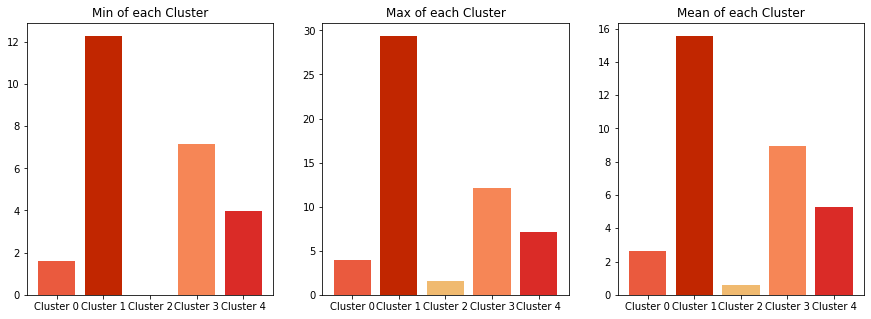

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.bar(['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4'],
        [describe_0.iloc[3],describe_1.iloc[3],describe_2.iloc[3],describe_3.iloc[3],describe_4.iloc[3]],color=('#EA5A3E', '#C12600', '#F0BA70', '#F68656','#DA2B27'))
plt.title('Min of each Cluster')
plt.subplot(132)
plt.bar(['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4'],
        [describe_0.iloc[7],describe_1.iloc[7],describe_2.iloc[7],describe_3.iloc[7],describe_4.iloc[7]],color=('#EA5A3E', '#C12600', '#F0BA70', '#F68656','#DA2B27'))
plt.title('Max of each Cluster')
plt.subplot(133)
plt.bar(['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4'], 
        [describe_0.iloc[1],describe_1.iloc[1],describe_2.iloc[1],describe_3.iloc[1],describe_4.iloc[1]],color=('#EA5A3E', '#C12600', '#F0BA70', '#F68656','#DA2B27'))
plt.title('Mean of each Cluster')
plt.show()

#### Below we can see how distances have been divided and which range is covered by which cluster.

![title|3380 × 1810,20%](img/numberline.png)

In [56]:
cluster_0=cluster_0.head(50)
cluster_1=cluster_1.head(50)
cluster_2=cluster_2.head(50)
cluster_3=cluster_3.head(50)
cluster_4=cluster_4.head(50)

###### Visualization a few points from each of the clusters.

In [57]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

rainbow = ['#1ec4dc','#4d6fbe','#369acd','#6644af','#07efeb']

for lat, lon, venue, cluster,suburb in zip(cluster_0['Venue Latitude'], cluster_0['Venue Longitude'], cluster_0['Venue'],cluster_0['Cluster Labels'],cluster_0['Suburb']):
    label = folium.Popup(venue +', '+ suburb + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[0],
        fill=True,
        fill_color=rainbow[0],
        fill_opacity=0.8).add_to(map_clusters)

for lat, lon, venue, cluster,suburb in zip(cluster_1['Venue Latitude'], cluster_1['Venue Longitude'], cluster_1['Venue'],cluster_1['Cluster Labels'],cluster_1['Suburb']):
    label = folium.Popup(venue +', '+ suburb + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[1],
        fill=True,
        fill_color=rainbow[1],
        fill_opacity=0.8).add_to(map_clusters)
           
for lat, lon, venue, cluster,suburb in zip(cluster_2['Venue Latitude'], cluster_2['Venue Longitude'], cluster_2['Venue'],cluster_2['Cluster Labels'],cluster_2['Suburb']):
    label = folium.Popup(venue +', '+ suburb + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[2],
        fill=True,
        fill_color=rainbow[2],
        fill_opacity=0.8).add_to(map_clusters)
           
for lat, lon, venue, cluster,suburb in zip(cluster_3['Venue Latitude'], cluster_3['Venue Longitude'], cluster_3['Venue'],cluster_3['Cluster Labels'],cluster_3['Suburb']):
    label = folium.Popup(venue +', '+ suburb + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[3],
        fill=True,
        fill_color=rainbow[3],
        fill_opacity=0.8).add_to(map_clusters)
       
for lat, lon, venue, cluster,suburb in zip(cluster_4['Venue Latitude'], cluster_4['Venue Longitude'], cluster_4['Venue'],cluster_4['Cluster Labels'],cluster_4['Suburb']):
    label = folium.Popup(venue +', '+ suburb + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[4],
        fill=True,
        fill_color=rainbow[4],
        fill_opacity=0.8).add_to(map_clusters)
    
for lat, lng, station in zip(sydney_stations['Latitude'], sydney_stations['Longitude'], sydney_stations['Station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
        radius=3,
        popup=label,
        color='#008000',
        fill=True,
        fill_color='#3CB371	',
        fill_opacity=0.9,
        parse_html=False).add_to(map_clusters)  
    
map_clusters

In [58]:
clusters = pd.DataFrame()
clusters= top_food_places.loc[(top_food_places['Cluster Labels'] == 2)]
subs =clusters['Suburb'].value_counts()
stats =clusters['Nearest Station'].value_counts()

In [59]:
subs

Woolooware       20
Strathfield      20
Lavender Bay     20
Wolli Creek      20
Willoughby       20
                 ..
Bidwill           1
Henley            1
Shalvey           1
Huntleys Cove     1
Parklea           1
Name: Suburb, Length: 496, dtype: int64

In [60]:
stats

Chatswood Railway Station       294
Rhodes Railway Station          274
Town Hall Railway Station       221
Museum Railway Station          208
Burwood Railway Station         184
                               ... 
Warwick Farm Railway Station      2
Loftus Railway Station            2
Waverton Railway Station          1
Waterfall Railway Station         1
Canterbury Railway Station        1
Name: Nearest Station, Length: 156, dtype: int64

## Results and Discussion <a name="results"></a>

On close inspection of the details of the clusters, we see that cluster 2 has the places within walkable distance of train stations with a maximum distance of 1.6 kilometers.

Suburbs like Strathfield, Lavender Bay, Darling Point, Ashfield and a few other suburbs have a majority of food places which are nearest to train stations.

The Chatswood Railway Station has the most food places within walkable distance.

Multiple other inferences can be made from the analysis done according to the needs and interests of the traveler.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify the trending food ventures in Sydney with accessible public transportation. Sydney had around 600 plus suburbs in the city with an excellent metro system and an amazing variety of cuisines available to gorge on. By calculating the distance from the nearest train stations and clustering restaurants based on this distance, anyone new to the beautiful city of Sydney can enjoy their food and accommodating public transport facilities. 

This project can be further extended by creating analysis of food places closest to both train stations and the iconic places to visit in Sydney like the Opera House and its famous beaches.

## Bon Voyage and Bon Appetit ! 